In [17]:
%load_ext autoreload
%autoreload 2

from hwacctools.comp_graph import splitter, cnodes, cgraph, core
import onnx
from onnx import numpy_helper as nphelp
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import onnxruntime as ort
from onnx import helper
import hwacctools.onnx_utils as onnx_utils
import pandas as pd
import hwacctools.onnx_tools.onnx_splitter as onnx_splitter
import rectpack
import tqdm
import seaborn as sns


df = pd.DataFrame

def get_packer_string(df_row):
    if df_row['Naive']:
        return 'Naive'
    
    df_row['Offline'] = 'OFF' if df_row['Offline'] else 'ON'
    df_row['SortAlgo'] = '' if df_row['SortAlgo'] == 'SORT_NONE' else df_row['SortAlgo']
    df_row['PackAlgo'] = 'MR' if df_row['PackAlgo'] == 'MaxRectsBssf' else 'SKY'

    return f"{df_row['Offline']}_{df_row['BinAlgo']}_{df_row['PackAlgo']}{df_row['SortAlgo']}"

def get_model_name(df_row):
    return df_row['modelpath'].split('/')[-1].split('.')[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Online,
    bin_algo=rectpack.PackingBin.BBF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBaf,
    # sort_algo=rectpack.SORT_AREA
)
core_size = (256, 256)

for modelpath in modelpaths:
    nx_model = onnx.load(modelpath)
    u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer, naive=True)
    u_marped.plot(name = f'{modelpath}')

In [25]:
# Setup sweeps for packing experiments

from hwacctools.comp_graph import packer_utils as pu

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packer_argument_headers = [
    'Naive','Offline','BinAlgo','PackAlgo','SortAlgo'
]
get_packer_arguments = [
    [True,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BFF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BFF','MaxRectsBssf','SORT_NONE'],
]
core_sizes = [(256,256),(512,512)]

In [37]:
results = []
with tqdm.tqdm(total=len(modelpaths) * len(core_sizes) * len(get_packer_arguments), desc="Total Progress") as pbar:
    for modelpath in modelpaths:
        for core_size in core_sizes:
            for args in get_packer_arguments:
                packer = pu.get_packer(*args, core_size=core_size)
                nx_model = onnx.load(modelpath)
                u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)

                if not u_marped.success:
                    print(f"Packing failed for {modelpath} with core size {core_size} and arguments {args}")
                    pbar.update(1)
                    continue

                u_qracc = core.QRAccModel(packed_cgraph=u_marped, num_cores=1)
                results.append({
                    'modelpath': modelpath,
                    'core_size': core_size,
                    'utilization': u_qracc.utilization,
                    'bin_writes': u_qracc.weight_bin_writes,
                    'nbins': u_marped.nbins,
                    **dict(zip(packer_argument_headers, args))
                })
                pbar.update(1)

df = pd.DataFrame(results)
df.to_csv('experiment_results.csv', index=False)

Total Progress: 100%|██████████| 56/56 [00:07<00:00,  7.22it/s]


In [38]:
df

,modelpath,core_size,utilization,bin_writes,nbins,Naive,Offline,BinAlgo,PackAlgo,SortAlgo
0,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.287946,15,14,True,True,BBF,MaxRectsBssf,SORT_NONE
1,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,True,BBF,MaxRectsBssf,SORT_NONE
2,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,6,5,False,True,BNF,MaxRectsBssf,SORT_NONE
3,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,True,BFF,MaxRectsBssf,SORT_NONE
4,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,False,BBF,MaxRectsBssf,SORT_NONE
5,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,6,5,False,False,BNF,MaxRectsBssf,SORT_NONE
6,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,False,BFF,MaxRectsBssf,SORT_NONE
7,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.083984,13,12,True,True,BBF,MaxRectsBssf,SORT_NONE
8,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.503906,4,2,False,True,BBF,MaxRectsBssf,SORT_NONE
9,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.503906,3,2,False,True,BNF,MaxRectsBssf,SORT_NONE


In [27]:
df = pd.read_csv('experiment_results.csv')
df['PackerArgs'] = df.apply(get_packer_string, axis=1)
df['ModelName'] = df.apply(get_model_name, axis=1)
df.drop(columns=packer_argument_headers, inplace=True)
df.drop(columns=['modelpath'], inplace=True)

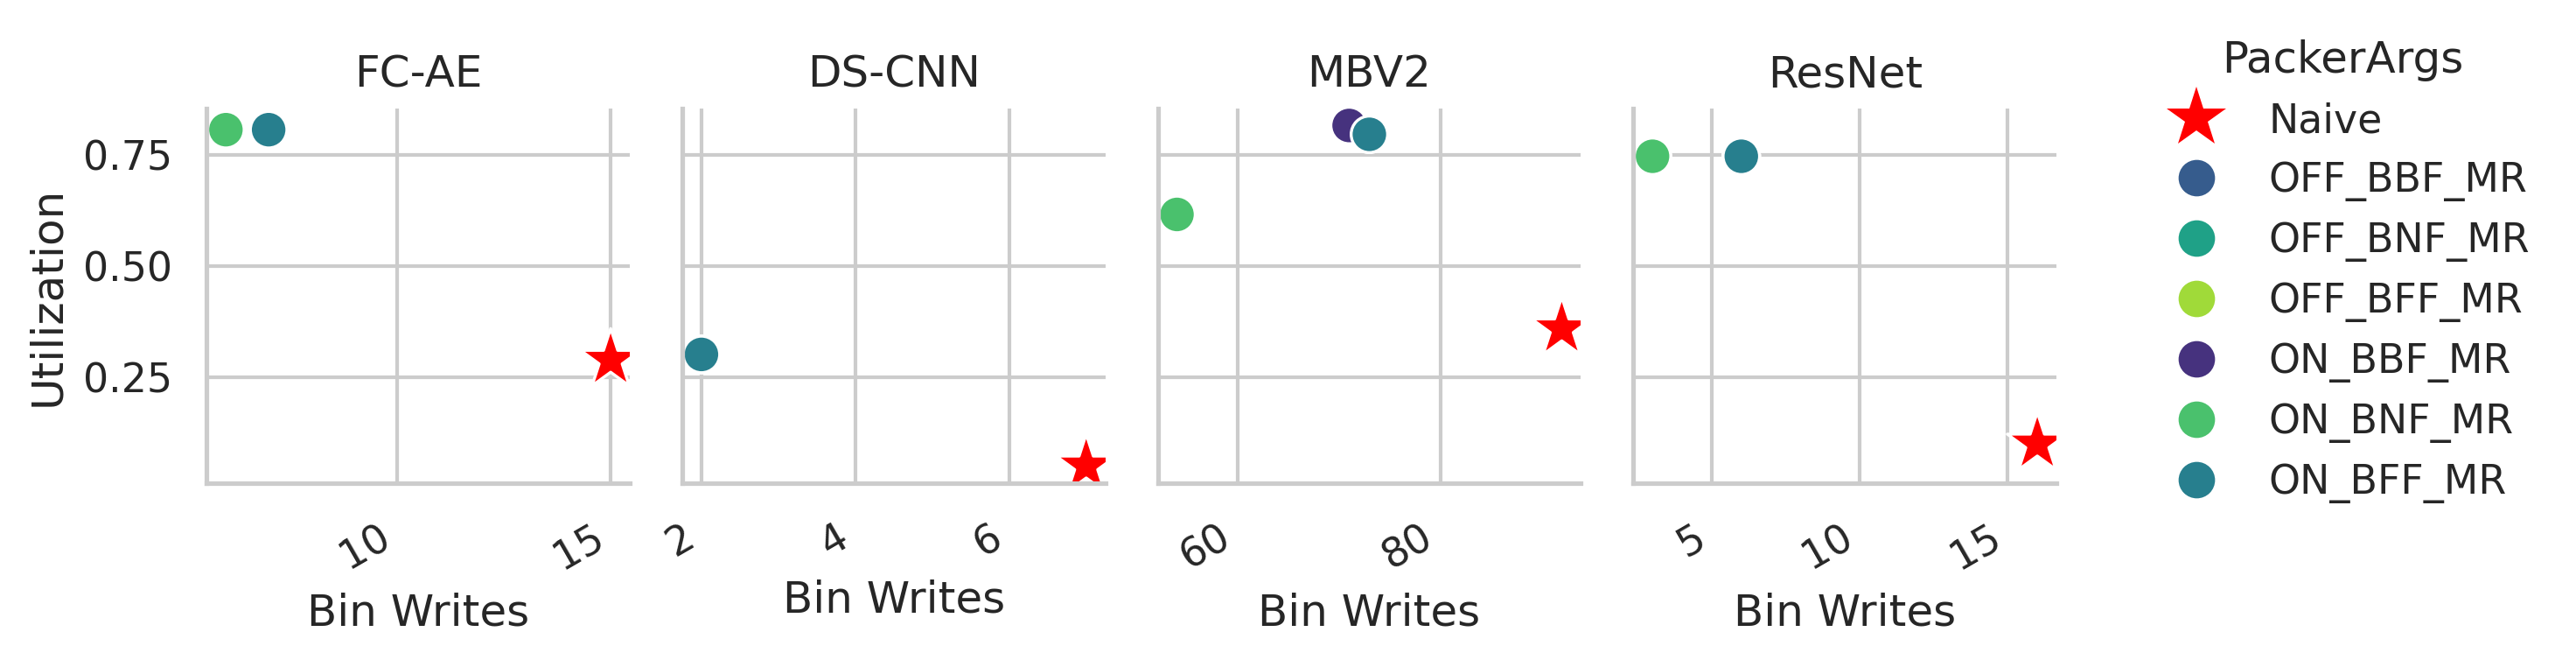

In [21]:
sns.set_theme(style="whitegrid")
# Create a new column for marker and color
df['Marker'] = df['PackerArgs'].apply(lambda x: '*' if x == 'Naive' else 'o')
df['Color'] = df['PackerArgs'].apply(lambda x: 'red' if x == 'Naive' else None)

df = df[df['core_size'] == '(256, 256)']

marker_dict = {
    'Naive': '*',
    'ON_BBF_MR': 'o',
    'OFF_BBF_MR': 'o',
    'ON_BFF_MR': 'o',
    'OFF_BNF_MR': 'o',
    'ON_BNF_MR': 'o',
    'OFF_BFF_MR': 'o'
}

sizes_dict = {
    'Naive': 300,
    'ON_BBF_MR': 100,
    'OFF_BBF_MR': 100,
    'ON_BFF_MR': 100,
    'OFF_BNF_MR': 100,
    'ON_BNF_MR': 100,
    'OFF_BFF_MR': 100
}

# Create a color palette based on viridis, but set 'Naive' to red
viridis_palette = sns.color_palette("viridis", n_colors=len(marker_dict) - 1)
custom_palette = {'Naive': 'red'}
for k, c in zip([k for k in marker_dict if k != 'Naive'], viridis_palette):
    custom_palette[k] = c

# Plot with custom markers and colors
g = sns.relplot(
    data=df,
    x='bin_writes',
    y='utilization',
    col='ModelName',
    row='core_size',
    hue='PackerArgs',
    kind='scatter',
    palette=custom_palette,
    facet_kws={'sharey': True, 'sharex': False},
    size='PackerArgs',
    sizes=sizes_dict,  # use sizes_dict to set marker sizes
    style='PackerArgs',  # use style to distinguish 'Naive'
    markers=marker_dict
)

# Set red color for 'Naive' points
for ax in g.axes.flat:
    for path_collection, label in zip(ax.collections, g._legend_data.keys()):
        if label == 'Naive':
            path_collection.set_color('red')
g.figure.set_size_inches(8, 2.5)
g.figure.set_dpi(300)
plt.tight_layout()

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')
# rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

title_dict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet',
}

# remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())
# set titles
for ax in g.axes.flat:
    ax.set_title(title_dict[ax.get_title()])
# set x labels to 'Bin Writes'
for ax in g.axes.flat:
    ax.set_xlabel('Bin Writes')
# set y labels to 'Utilization'
for ax in g.axes.flat:
    ax.set_ylabel('Utilization')

In [36]:
# Get rows where packer is naive
naive_rows = df[df['PackerArgs'] == 'Naive']
naive_rows = naive_rows.sort_values(by='utilization', ascending=False)
# Use model name as index and pivot the core size
naive_rows = naive_rows.pivot(index='ModelName', columns='core_size', values='utilization')
naive_rows

ModelNameDict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet'
}

# Rename the index using ModelNameDict
naive_rows.index = naive_rows.index.map(ModelNameDict)
naive_rows.to_csv('naive_mlperftiny.csv')

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>core_size</th>\n      <th>(256, 256)</th>\n      <th>(256, 64)</th>\n      <th>(512, 512)</th>\n    </tr>\n    <tr>\n      <th>ModelName</th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>FC-AE</th>\n      <td>0.287946</td>\n      <td>0.031250</td>\n      <td>0.083984</td>\n    </tr>\n    <tr>\n      <th>ResNet</th>\n      <td>0.099528</td>\n      <td>0.398112</td>\n      <td>0.033930</td>\n    </tr>\n    <tr>\n      <th>DS-CNN</th>\n      <td>0.050130</td>\n      <td>0.200521</td>\n      <td>0.012533</td>\n    </tr>\n    <tr>\n      <th>MBV2</th>\n      <td>0.358554</td>\n      <td>0.509819</td>\n      <td>0.156867</td>\n    </tr>\n  </tbody>\n</table>'